In [1]:
from pathlib import Path
from reload_recursive import reload_recursive
import mri_data
import monai_training
import platform
import pyperclip
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from loguru import logger
from tqdm.notebook import tqdm
import pandas as pd

import logging

from scipy.spatial import ConvexHull, convex_hull_plot_2d, distance
from scipy import ndimage
from sklearn.cluster import HDBSCAN

In [2]:
reload_recursive(mri_data)
reload_recursive(monai_training)
from mri_data.file_manager import scan_3Tpioneer_bids, DataSet, filter_first_ses  # noqa: E402, F401
import mri_data.file_manager as fm
from mri_data import utils
from monai_training import preprocess  # noqa: E402
from monai_training.preprocess import DataSetProcesser

In [3]:
logger.remove()
logging.basicConfig(level=logging.ERROR)

In [4]:
hostname = platform.node()
if hostname == "ryzen9":
    drive_root = Path("/media/smbshare")
else:
    drive_root = Path("/mnt/h")

projects_root = Path("/home/srs-9/Projects")
training_work_dirs = drive_root / "srs-9" / "training_work_dirs"
msmri_home = projects_root / "ms_mri"
project_dataroot = msmri_home / "data"

prediction_postfix = "choroid_pineal_pituitary_T1-1_pred"
modalities = ["t1"]

inference_root = drive_root / "srs-9" / "3Tpioneer_bids_predictions"
prediction_filename = (
    ".".join(sorted(modalities)) + "_" + prediction_postfix + ".nii.gz"
)
dataroot = drive_root / "3Tpioneer_bids"
work_dir_name = "choroid_pineal_pituitary_T1-1"
work_dir = training_work_dirs / work_dir_name
ensemble_out_dir = work_dir / "ensemble_output"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary_T1-1"

In [5]:
inference_proc = DataSetProcesser.new_dataset(
    inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses],
    label=prediction_filename
)
inference_proc.filter([fm.has_label])
inference_proc.dataset.sort()
inference_dataset = inference_proc.dataset
# inference_dataset = [scan for scan in inference_dataset if scan.label is not None]

In [6]:
dataset_proc = DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
dataset_proc.prepare_labels(["choroid_t1_flair", "pineal", "pituitary"], suffix_list=["CH", "SRS", "ED", "DT"])
dataset = dataset_proc.dataset
dataset.sort()

100%|██████████| 575/575 [00:02<00:00, 207.26it/s]


In [7]:
scans = dataset.scans + inference_dataset.scans

In [8]:
def load_segmentation(scan, label=None):
    seg = nib.load(scan.label_path).get_fdata()
    if label is None:
        return seg
    
    labels = ["choroid", "pineal", "pituitary"]
    try:
        val = labels.index(label) + 1
    except ValueError:
        print(f"Invalid value for label passed ({label})")
        raise

    seg_all = seg
    seg[seg_all != val] = 0
    seg[seg_all == val] = 1
    return seg

def split_segmentation(seg):
    seg_all = seg
    segs = []
    for val in range(1, int(np.max(seg))+1):
        seg[seg_all != val] = 0
        seg[seg_all == val] = 1
        segs.append(seg)
    
    return segs

In [9]:
def centroid_dists(seg):
    points = np.argwhere(seg > 0)
    hdb = HDBSCAN()
    hdb.store_centers = "centroid"
    hdb.fit(points)
    centroid = ndimage.center_of_mass(seg)

    w_sum = 0
    for i in range(np.max(hdb.labels_) + 1):
        w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(points)
    
    return w_sum

def get_volumes(scan):
    vol_stats = utils.compute_volume(scan.label_path, index_mask_file=scan.label_path)
    
    return tuple([stat[1] for stat in vol_stats])

In [10]:
all_segs = (split_segmentation(load_segmentation(scan)) for scan in scans)

In [13]:
df_full = pd.read_csv(curr_dir / "clinical_data_full.csv", index_col="subid")
p = Path("/mnt/h")
for i, row in df_full.iterrows():
    try:
        df_full.loc[i, "label"] = str(p / row.label)
    except TypeError:
        pass
    try:
        df_full.loc[i, "scan_folder"] = str(p / row.scan_folder)
    except TypeError:
        pass

In [14]:
keep_cols = ["ms_type", "flair_contrast", "choroid_volume", "pineal_volume", "pituitary_volume", "scan_folder", "label"]
df_full = pd.read_csv(curr_dir / "clinical_data_full.csv", index_col="subid")
df_full.index.name = "subject_id"
df_full = df_full[keep_cols]
try:
    df_full.insert('dz_type', df_full['ms_type'])
except Exception:
    pass

df_full.loc[:, 'dz_type'] = df_full['ms_type']

df_full.loc[df_full['ms_type'] == 'CIS', 'dz_type'] = 'RRMS'
df_full.loc[df_full['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df_full.loc[df_full['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'

df_full.loc[:, 'dz_type2'] = df_full['dz_type']
df_full.loc[df_full['dz_type'].isin(['RRMS', 'PMS']), 'dz_type2'] = 'MS'

not_nas = (~df_full['pineal_volume'].isna() & ~df_full['choroid_volume'].isna() & ~df_full['pituitary_volume'].isna())
df = df_full.loc[not_nas, :]

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [15]:
try:
    df.insert(18, 'dz_type', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type'] = df['ms_type']

df.loc[df['ms_type'].isin(['CIS', 'RRMS']), 'dz_type'] = 'RMS'
df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS']), 'dz_type'] = 'PMS'
df.loc[df['ms_type'].isin(['NIND', 'OIND', 'HC']), 'dz_type'] = '!MS'
df['dz_type'].unique()

array(['RMS', 'PMS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type2` has MS versus !MS and UNK

In [16]:
try:
    df.insert(18, 'dz_type2', df['dz_type'])
except Exception:
    pass

df.loc[:, 'dz_type2'] = df['dz_type']

df.loc[df['dz_type'].isin(['RMS', 'PMS']), 'dz_type2'] = 'MS'
df['dz_type2'].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [17]:
try:
    df.insert(18, 'dz_type3', df['ms_type'])
except Exception:
    pass

df.loc[:, 'dz_type3'] = df['ms_type']

df.loc[df['ms_type'].isin(['PPMS', 'SPMS', 'RPMS', 'PRMS', 'RRMS', 'CIS']), 'dz_type3'] = 'MS'
df['dz_type3'].unique()

/tmp/ipykernel_251169/3034911079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'dz_type3'] = df['ms_type']


array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

## Inspect Inferences

In [47]:
for i, row in df.iterrows():
    images = [drive_root / row['scan_folder'] / "flair.nii.gz", drive_root / row['scan_folder'] / "t1.nii.gz"]
    labels = [drive_root / row['label']]
    cmd = utils.open_itksnap_workspace_cmd(images, labels, win=True)
    df.loc[i, "itksnap_cmd"] = cmd

/tmp/ipykernel_474682/2503728320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, "itksnap_cmd"] = cmd


### Manual Labels

In [14]:
subjects = [
    1010,
    1011,
    1019,
    1033,
    1065,
    1080,
    1109,
    1119,
    1152,
    1163,
    1188,
    1191,
    1234,
    1259,
    1265,
    1272,
    1280,
    1293,
    1321,
    1355,
    1437,
    1486,
    1498,
    1518,
    1540,
    1547,
    1548,
    2081,
    2083,
    2097,
    2126,
    2132,
    2144,
    2146,
    2164,
    2187,
]
df_subset = df.loc[subjects]

In [87]:
scan = inference_dataset[33]
img = nib.load(scan.label_path)
seg = img.get_fdata()
seg_pineal = seg
seg_pineal[seg!=2] = 0
seg_pineal[seg==2] = 1
pineal_points = np.argwhere(seg_pineal > 0)

hdb = HDBSCAN()
hdb.store_centers = "centroid"
hdb.fit(pineal_points)
centroid = ndimage.center_of_mass(seg_pineal)

w_sum = 0
for i in range(np.max(hdb.labels_) + 1):
    w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(pineal_points)

print(w_sum)
print(hdb.labels_.max())

0.22166953884404933
1


In [ ]:
w_sums = []
n_labels = []
subs = []
for scan in inference_dataset:
    try:
        img = nib.load(scan.label_path)
    except Exception:
        continue
    seg = img.get_fdata()
    seg_pineal = seg
    seg_pineal[seg!=2] = 0
    seg_pineal[seg==2] = 1
    pineal_points = np.argwhere(seg_pineal > 0)

    hdb = HDBSCAN()
    hdb.store_centers = "centroid"
    hdb.fit(pineal_points)
    centroid = ndimage.center_of_mass(seg_pineal)

    w_sum = 0
    for i in range(np.max(hdb.labels_) + 1):
        w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(pineal_points)

    w_sums.append(w_sum)
    n_labels.append(hdb.labels_.max())
    subs.append(scan.subid)

In [72]:
hdb = HDBSCAN()
hdb.store_centers = "centroid"
hdb.fit(pineal_points)
centroid = ndimage.center_of_mass(seg_pineal)

w_sum = 0
for i in range(np.max(hdb.labels_) + 1):
    w_sum = w_sum + distance.euclidean(centroid, hdb.centroids_[i]) * sum(hdb.labels_ == i) / len(pineal_points)

print(w_sum)
print(hdb.labels_.max())

0.17094253266313877
1


1

In [15]:
thoo = [list() for i in range(3)]
thoo[0].append(1)
print(thoo)

[[1], [], []]


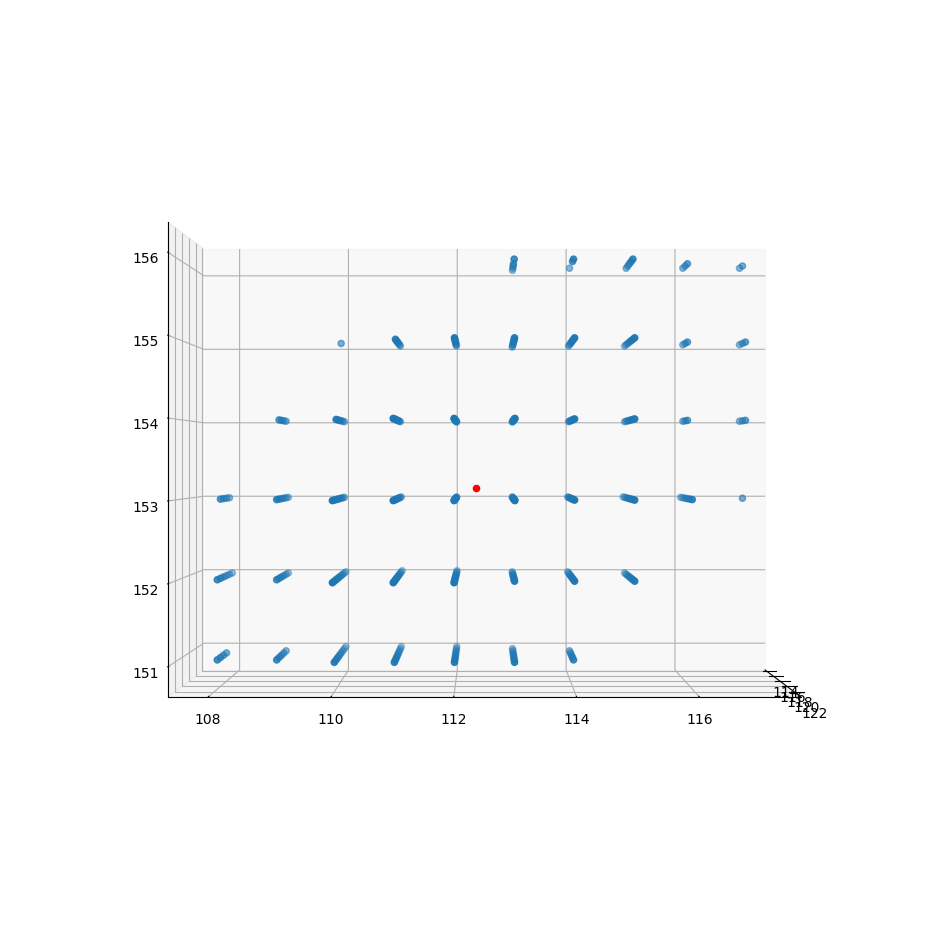

In [25]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pineal_points[:,0], pineal_points[:,1], pineal_points[:,2])
ax.scatter(centroid[0], centroid[1], centroid[2], c='red')
ax.view_init(azim=0, elev=0)

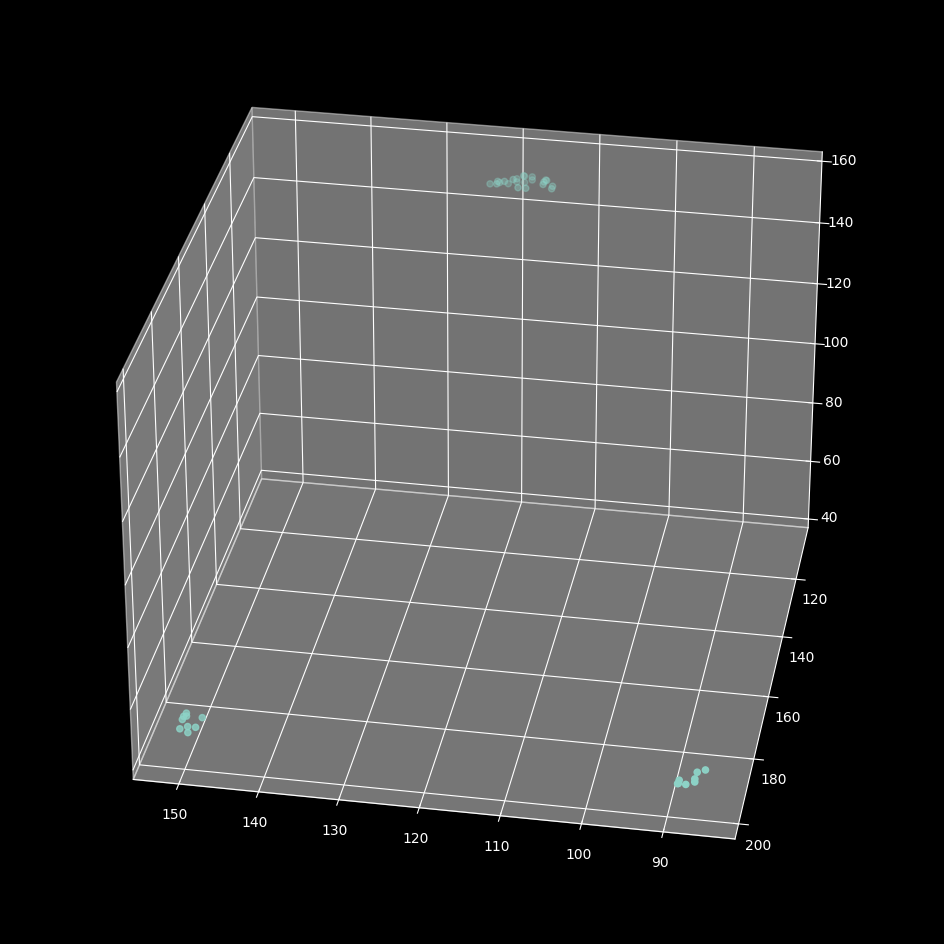

In [55]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], hull.points[hull.vertices, 2])
ax.view_init(azim=100, elev=30)